In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from datetime import date, timedelta
from tqdm import tqdm
from texttable import Texttable
from scipy.stats import linregress
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (22,10)

In [3]:
IPC_stocks = ['^MXX', 'KIMBERA.MX', 'GCC.MX', 'CUERVO.MX', 'CEMEXCPO.MX', 'PINFRA.MX', 'GENTERA.MX', 'GRUMAB.MX', 'RA.MX', 'AC.MX', 
              'BSMXB.MX', 'ALPEKA.MX', 'BBAJIOO.MX', 'AMXL.MX', 'GMEXICOB.MX', 'LABB.MX', 'IENOVA.MX', 'ASURB.MX', 'ALSEA.MX', 'BOLSAA.MX', 
              'GCARSOA1.MX', 'MEGACPO.MX', 'TLEVISACPO.MX', 'LIVEPOLC-1.MX', 'BIMBOA.MX', 'GFNORTEO.MX', 'GAPB.MX', 'MEXCHEM.MX', 'PE&OLES.MX', 'OMAB.MX']

In [4]:
IPC_data = yf.download(IPC_stocks)

[*********************100%***********************]  30 of 30 downloaded


In [5]:
IPC_data['Close'].tail()

,AC.MX,ALPEKA.MX,ALSEA.MX,AMXL.MX,ASURB.MX,BBAJIOO.MX,BIMBOA.MX,BOLSAA.MX,BSMXB.MX,CEMEXCPO.MX,...,LABB.MX,LIVEPOLC-1.MX,MEGACPO.MX,MEXCHEM.MX,OMAB.MX,PE&OLES.MX,PINFRA.MX,RA.MX,TLEVISACPO.MX,^MXX
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-07,107.97,22.07,48.29,14.68,300.97,32.24,34.98,37.24,NaN,7.21,...,19.18,107.82,84.06,NaN,117.68,249.89,177.74,93.73,38.56,42952.29
2019-10-08,109.48,21.61,48.01,14.57,303.57,32.66,34.72,36.58,NaN,7.35,...,18.56,106.51,83.53,NaN,117.66,245.34,179.92,95.44,38.68,42535.14
2019-10-09,109.60,21.83,47.96,14.60,300.95,32.97,35.03,36.45,NaN,7.47,...,18.19,105.02,80.51,NaN,120.25,245.10,178.70,94.64,38.62,42501.92
2019-10-10,109.05,21.87,47.59,14.88,304.98,32.16,35.39,36.61,NaN,7.56,...,18.55,106.04,79.38,NaN,122.03,242.71,177.98,95.29,39.93,42929.76
2019-10-11,109.11,22.09,48.98,14.89,304.24,32.18,35.70,36.86,26.57,7.78,...,18.80,108.24,82.89,NaN,123.42,237.56,178.00,94.86,41.18,43214.60


In [6]:
Close = IPC_data['Close'][IPC_data.index.dayofweek == 4]

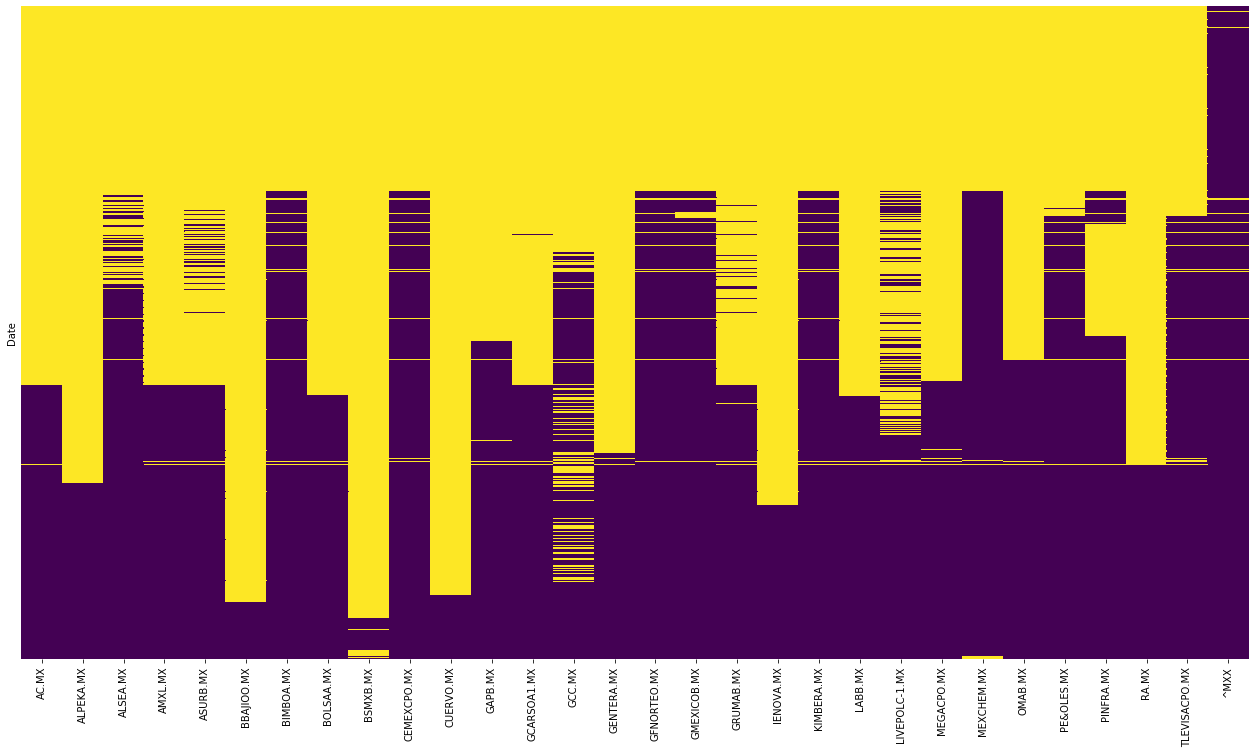

In [7]:
plt.figure(figsize=(22,12))
sns.heatmap(Close.isna(), cmap='viridis', cbar=False, yticklabels=False);

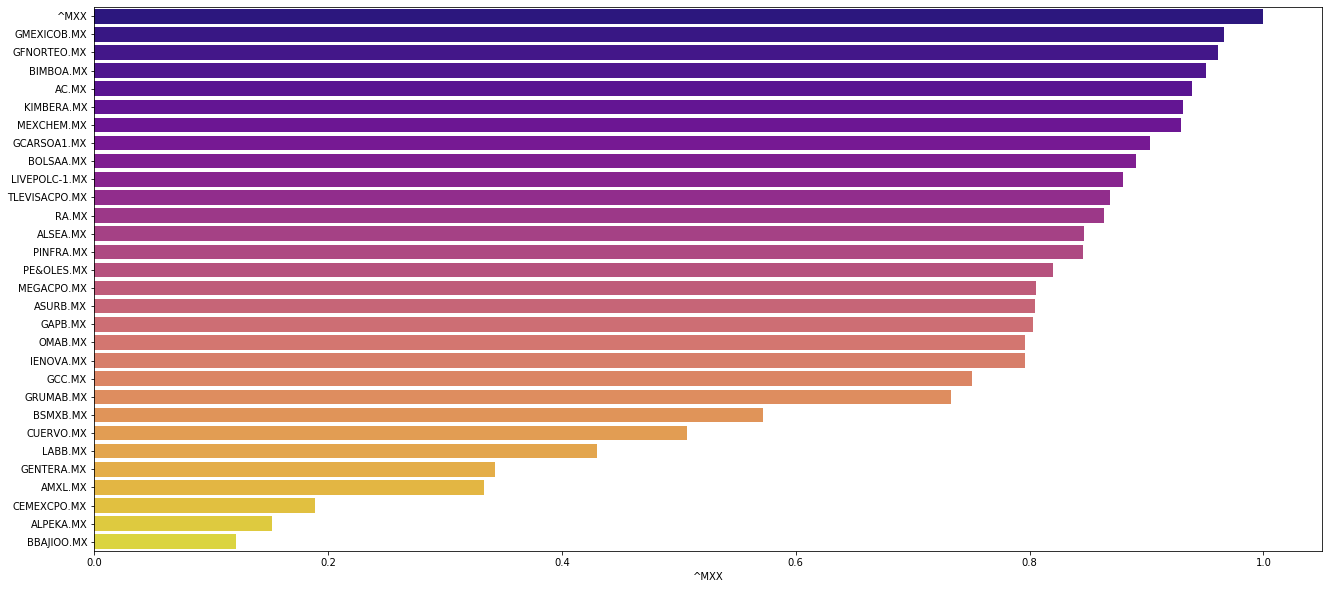

In [31]:
rank = Close.corr()['^MXX'].abs().sort_values(ascending=False)
sns.barplot(x=rank, y=rank.index, palette='plasma');

In [8]:
def predict_stock(stock, iterations=1000, plot=False):
    
    if stock.notna().sum() < 50:                                                                         # Check for non empty data
        print('Not enough data!')
        return

    stock = stock[stock.notna()]                                                                          # Removing NA values
    stock_2019 = stock[stock.index.year == 2019]                                                          # Stock prices for 2019
    stock_r = stock[stock.index.year != 2019]                                                             # Stock prices for the rest of the years
    stock_lr = np.log1p(stock_r.pct_change())                                                             # Logaritmic returns
    stock_drift = stock_lr.mean() - 0.5 * stock_lr.var()                                                  # Stock Drift
    
    t_intervals = stock_2019.shape[0] + 50                                                                # Number of predictions
    
    stock_dr = np.exp(stock_drift + stock_lr.std() * norm.ppf(np.random.rand(t_intervals, iterations)))   # Stock Daily Return Simulations
    stock_prices = np.zeros_like(stock_dr)                                                                # Dummy array for future prices
    stock_prices[0] = stock_r[-1]                                                                         # First price equals to most recent real price

    for t in range(1, t_intervals):
        stock_prices[t] = stock_prices[t-1] * stock_dr[t]                                                 # Calculating future prices as function of time t-1
        
    r2_values = np.zeros(iterations)
    for c in range(iterations):
        r2_values[c] = r2_score(stock_2019, stock_prices[:stock_2019.shape[0], c])                        # Calculating R2 for each iteration
    r2_best = r2_values.argsort()[-5:]                                                                    # Indices of best predictions
        
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(22,12))
        
        axes[0].plot(range(stock.shape[0]), stock)                                                        # Plot Stock price
        first = stock.shape[0] - stock_2019.shape[0]
        last = first + t_intervals
        for p in range(5):
            axes[0].plot(range(first, last), stock_prices[:, r2_best[p]], alpha=0.5)                      # Plot Best Predictions
            
        axes[1].plot(range(stock_2019.shape[0]), stock_2019, lw=5)                                        # Plot Stock price 2019
        for p in range(5):
            axes[1].scatter(range(stock_prices.shape[0]), stock_prices[:, r2_best[p]],                    # Plot Best Predictions
                         alpha=0.5, label=r2_values[r2_best[p]])      
        axes[1].scatter(stock_prices.shape[0], 
                        stock_prices[stock_2019.shape[0] + 1, r2_best[p]].mean(), marker='x')
                        
        plt.legend()
        plt.tight_layout()
            
    return stock_prices[stock_2019.shape[0], r2_best]

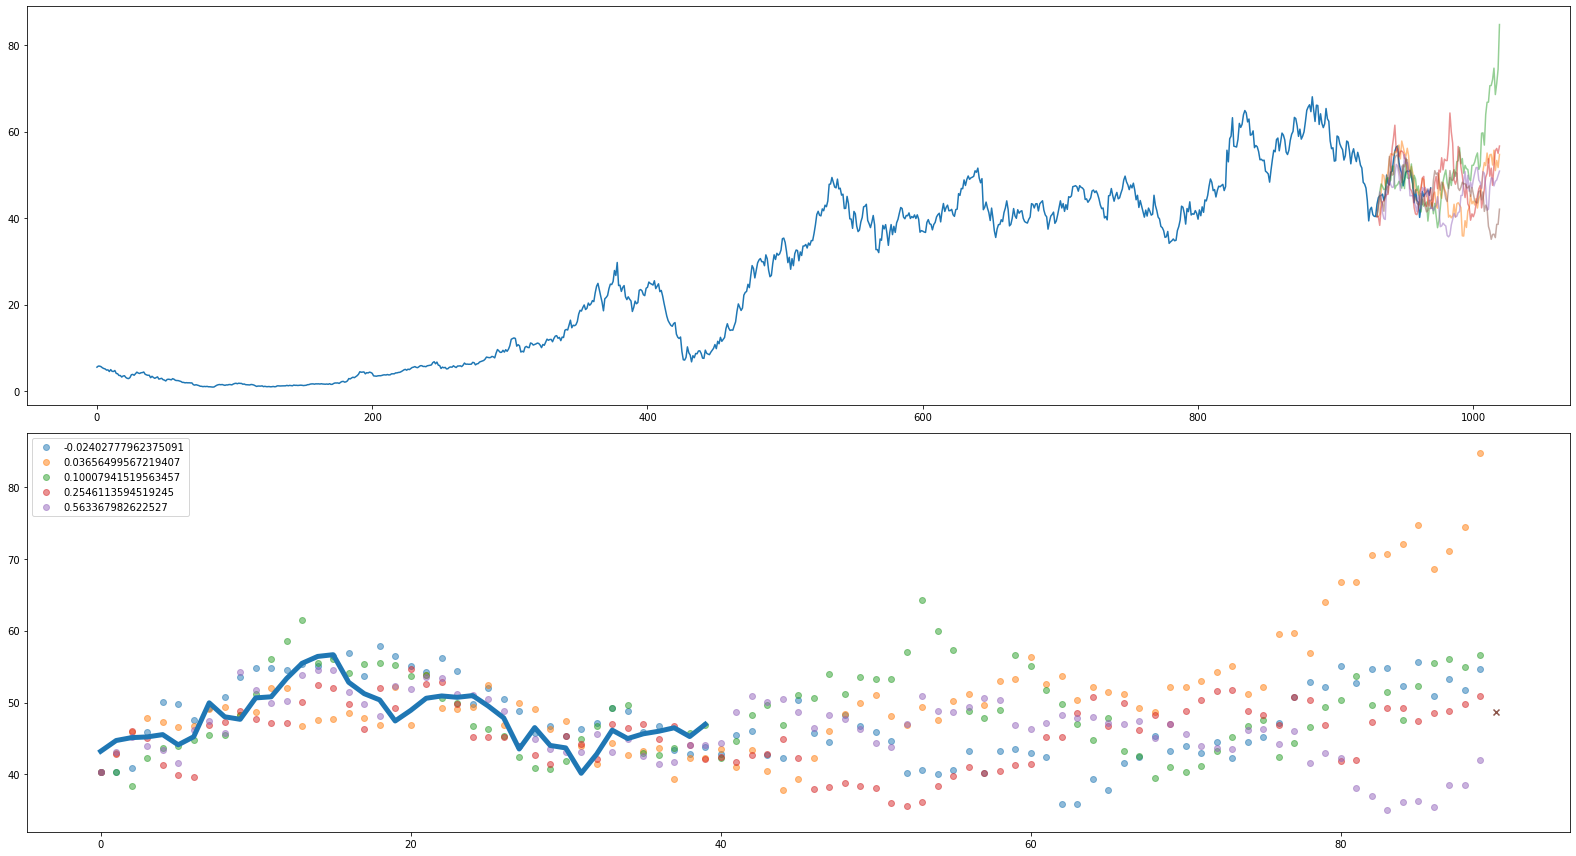

In [35]:
prediction = predict_stock(Close['GMEXICOB.MX'], plot=True)

In [87]:
predictions = np.zeros((2, Close.columns.shape[0] - 1))
for c in tqdm(range(Close.columns.shape[0] - 1)):
    p = predict_stock(Close[Close.columns[c]])
    predictions[0, c] = p.mean()
    predictions[1, c] = p[-1]

100%|██████████| 29/29 [00:11<00:00,  3.88it/s]


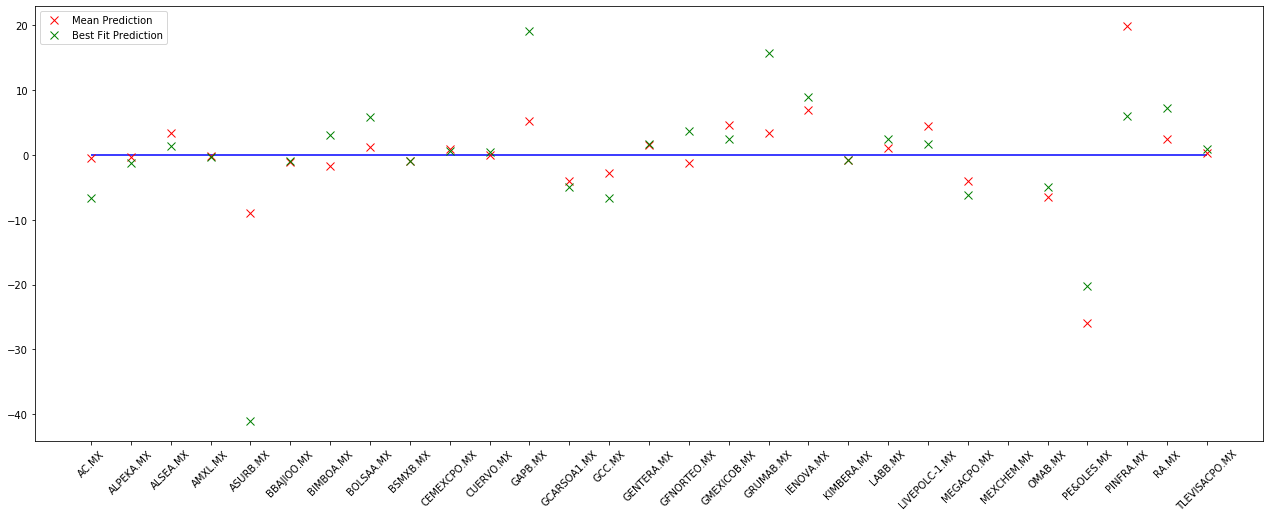

In [79]:
plt.figure(figsize=(22,8))
plt.plot(Close.iloc[-1][:-1] - predictions[0,:], 'rx', ms=8, label='Mean Prediction')
plt.plot(Close.iloc[-1][:-1] - predictions[1,:], 'gx', ms=8, label='Best Fit Prediction')
plt.hlines(0, Close.iloc[-1][:-1].index[0], Close.iloc[-1][:-1].index[-1], 'b')
plt.legend()
plt.xticks(rotation=45);

In [38]:
Close_train = Close[Close.index.year >= 2018].copy()

In [39]:
for c in Close_train.columns:
    Close_train[c].fillna(Close_train[c].mean(), inplace=True)

In [40]:
X = Close_train.drop(columns='^MXX').values
y = Close_train['^MXX'].values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [69]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [70]:
r2_score(y_train, model.predict(X_train))

0.9945062323145755

In [71]:
r2_score(y_test, model.predict(X_test))

0.9683201786161753

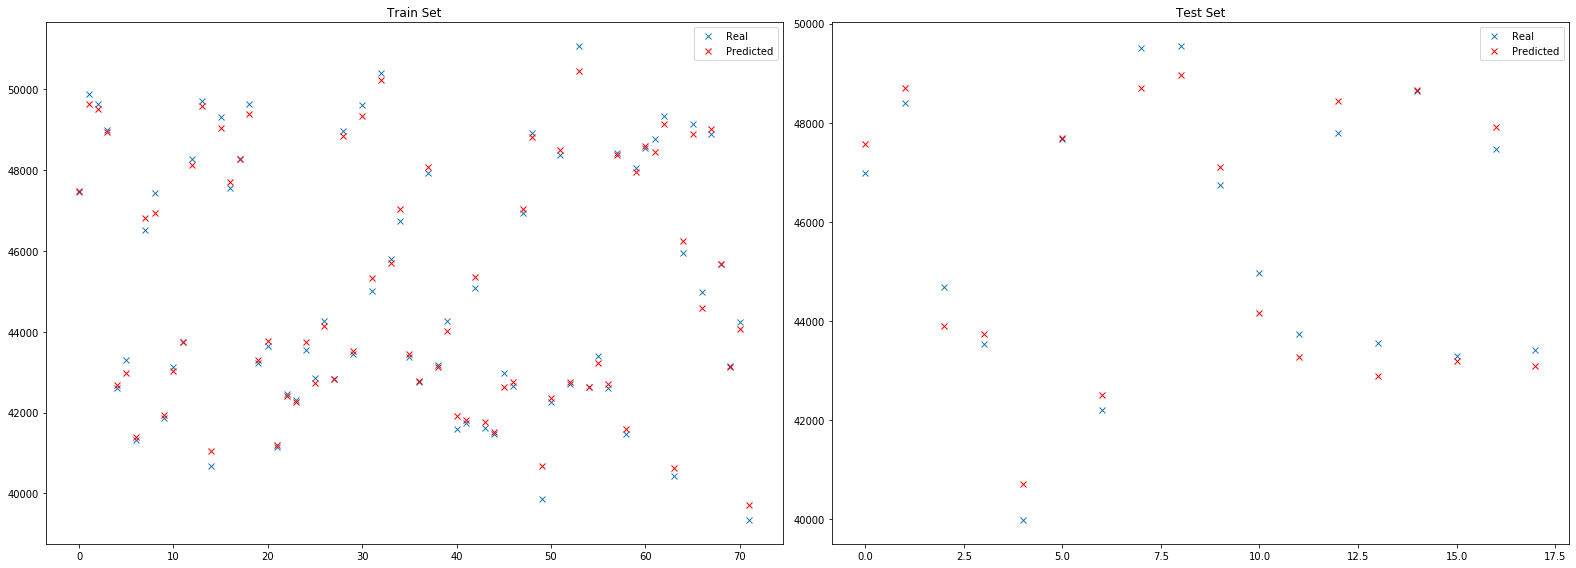

In [59]:
plt.figure(figsize=(22,8))
plt.subplot(121)
plt.plot(y_train, 'x', label='Real')
plt.plot(model.predict(X_train), 'rx', label='Predicted')
plt.title('Train Set')
plt.legend()

plt.subplot(122)
plt.plot(y_test, 'x', label='Real')
plt.plot(model.predict(X_test), 'rx', label='Predicted')
plt.title('Test Set')
plt.legend()
plt.tight_layout();

In [89]:
print(f'IPC Mean Prediction : {round(model.predict(predictions[0,:].reshape(1,-1))[0])}')
print(f'IPC BF Prediction : {round(model.predict(predictions[1,:].reshape(1,-1))[0])}')

IPC Mean Prediction : 42854.0
IPC BF Prediction : 42681.0


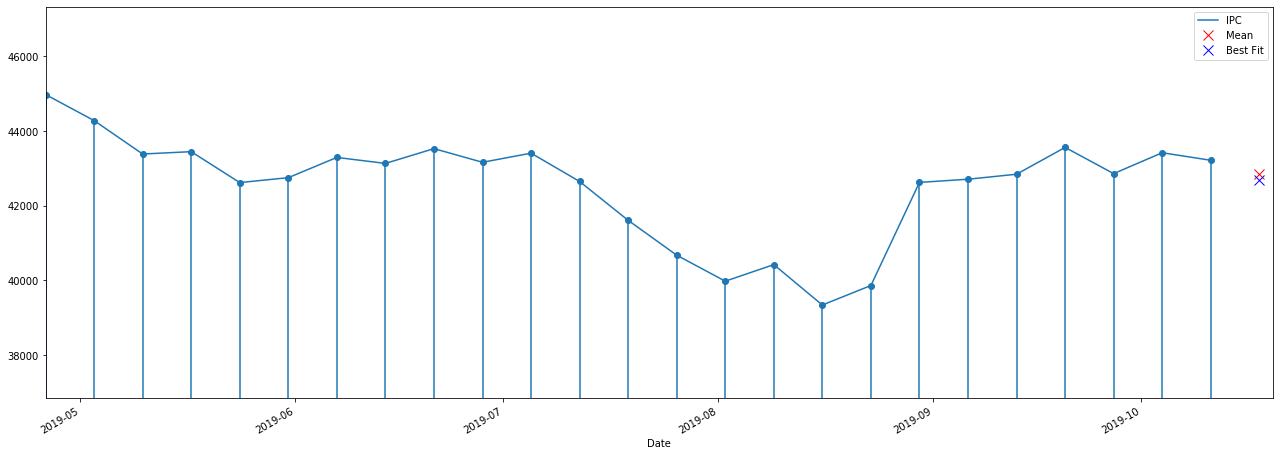

In [88]:
plt.figure(figsize=(22,8))
Close_train['^MXX'][-50:].plot(label='IPC')
plt.stem(Close_train['^MXX'][-50:].index, Close_train['^MXX'][-50:], use_line_collection=True)
plt.plot(Close_train['^MXX'].index[-1] + timedelta(7), round(model.predict(predictions[0,:].reshape(1,-1))[0]), 'rx', ms=10, label='Mean')
plt.plot(Close_train['^MXX'].index[-1] + timedelta(7), round(model.predict(predictions[1,:].reshape(1,-1))[0]), 'bx', ms=10, label='Best Fit')
plt.xlim(Close_train['^MXX'][-25:].index[0], Close_train['^MXX'].index[-1] + timedelta(9))
plt.ylim(Close_train['^MXX'][-50:].mean()-4*Close_train['^MXX'][-50:].std(), Close_train['^MXX'][-50:].mean()+3*Close_train['^MXX'][-50:].std())
plt.legend();